In [1]:
import time
import torch
import torch.nn as nn
import random
from sklearn.model_selection import KFold
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm
from PIL import Image

c:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(batch_size=32, train=True):
    '''
    Dataset loading will be handled for you automatically since it's a bit of a pain
    to work with these large datasets and I'll just give you a subset
    '''

    dataset = []
    batch_counter = 0
    batch = []
    num = 10000
    for i, file in enumerate(tqdm(os.listdir('./album_covers_512'))):
        if i >= num:
            break
        img = Image.open('./album_covers_512/' + file)
        img = np.asarray(img).reshape(3, 512, 512)

        if batch_counter < batch_size:
            batch.append(img)
            batch_counter += 1
        else:
            dataset.append(np.array(batch))
            batch = []
            batch_counter = 0

    return np.array(dataset)

In [3]:
dataset = load_data(batch_size=128, train=True)
dataset = torch.from_numpy(dataset)

 13%|█▎        | 10000/79734 [00:31<03:37, 320.34it/s]


In [5]:
def plot_image(image, index=0):
    # Make sure the tensor is on the CPU
    image = image.cpu().detach()
    
    # Assuming image is a PyTorch tensor, convert to numpy and normalize if necessary
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    # Select a single image if it's a batch
    # The image tensor should be of shape [batch_size, channels, height, width]
    if image.ndim == 4:
        # Select the image at the provided index
        image = image[index]
    
    # Normalize to [0, 1] if it's not already
    image = (image - image.min()) / (image.max() - image.min())
    
    # Convert from CHW to HWC format for matplotlib and reshape
    image = image.transpose((1, 2, 0))  # Use transpose instead of reshape
    
    plt.imshow(image)
    plt.show()


torch.Size([77, 128, 3, 512, 512])
image shape: torch.Size([3, 512, 512])


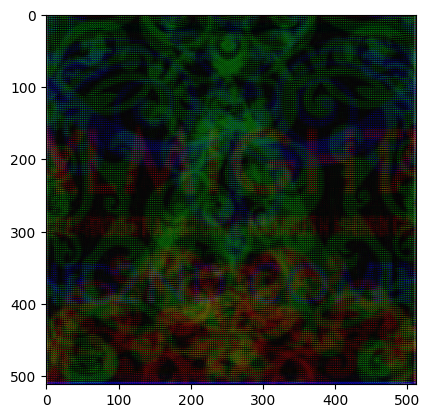

In [6]:
print(dataset.shape)
ex_image = dataset[random.randint(0,76), random.randint(0,127)]
print("image shape:", ex_image.shape)

plot_image(ex_image)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        # Calculate the number of features output by the conv layer
        output_features =  input_shape[1] * input_shape[2] * 16

        # Define linear layers using the correctly calculated size
        self.discriminator_linear = nn.Sequential(
            nn.Linear(output_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.discriminator_linear(x)
        return x


In [8]:
input_shape = (3, 512, 512)  # Shape: Channels, Height, Width
discriminator = Discriminator(input_shape)
ex_output = discriminator(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", ex_output[0].detach().numpy()[0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x262144 and 4194304x128)

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, output_shape):
        super(Generator, self).__init__()

        # TODO
       ####################################
        self.output_shape = output_shape
        
        # Calculate the flattened image size
        flat_image_size = output_shape[1] * output_shape[2] * output_shape[0]

        # Initial simple linear layers to map the input noise vector to the flattened output image size
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, flat_image_size),
            nn.ReLU(True)
        )
        
        # Note: Removed nn.Conv2d because it doesn't fit well directly after flattening without reshaping.
        # Adding a final layer to normalize the output to [-1, 1]
        self.final_layer = nn.Tanh()

        ####################################

    def forward(self, x):
        # TODO
       ####################################
        x = self.model(x)
        # Reshape the output to the desired output shape
        x = x.view(-1, *self.output_shape)
        out = self.final_layer(x)
        ####################################
        return out

torch.Size([1, 3, 512, 512])


C:\Users\andre\AppData\Local\Temp\ipykernel_4316\3938949174.py:16: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())
c:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


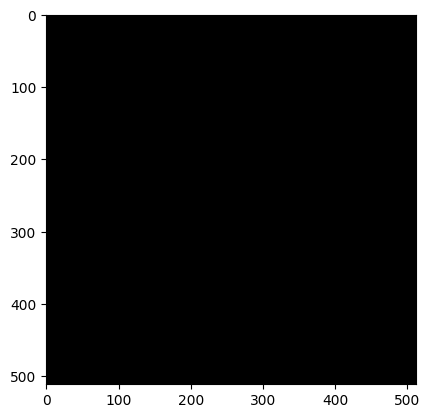

In [11]:
test_gen = Generator(128, (3, 512, 512))
print(test_gen(torch.rand(1, 128)).shape)
noise = (torch.rand(1, 128) - 0.5) / 0.5
test_output = test_gen(noise)

plot_image(test_output.detach().byte())

In [12]:
def training(generator, discriminator, loss, g_optimizer, d_optimizer, train_dataloader, n_epochs, update_interval, noise_samples):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    g_losses = []
    d_losses = []
    
    for epoch in range(n_epochs):
        for i, images in enumerate(tqdm(train_dataloader)):  # Adjusted for direct unpacking
            images = images.to(device).float()
            
            # Training the discriminator on real images
            real_classifications = discriminator(images)
            real_labels = torch.ones(images.size(0), 1, device=device)

            # Training the discriminator on fake images
            noise = (torch.rand(images.size(0), noise_samples, device=device) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            fake_labels = torch.zeros(images.size(0), 1, device=device)

            # Combine losses
            d_loss_real = loss(real_classifications, real_labels)
            d_loss_fake = loss(fake_classifications, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            if i % update_interval == 0:
                d_losses.append(round(d_loss.item(), 2))

            # Updating the generator
            noise = (torch.rand(images.size(0), noise_samples, device=device) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            
            # Inverting labels here: generator tries to fool the discriminator
            g_loss = loss(fake_classifications, real_labels)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if i % update_interval == 0:
                g_losses.append(round(g_loss.item(), 2))
                
    return (generator, discriminator), (g_losses, d_losses)


Using device: cuda


100%|██████████| 77/77 [00:29<00:00,  2.63it/s]


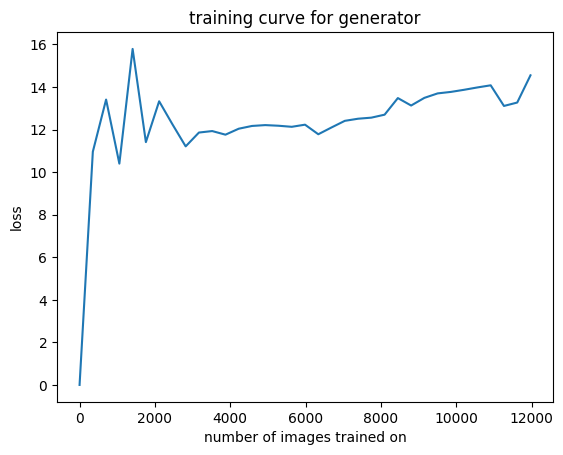

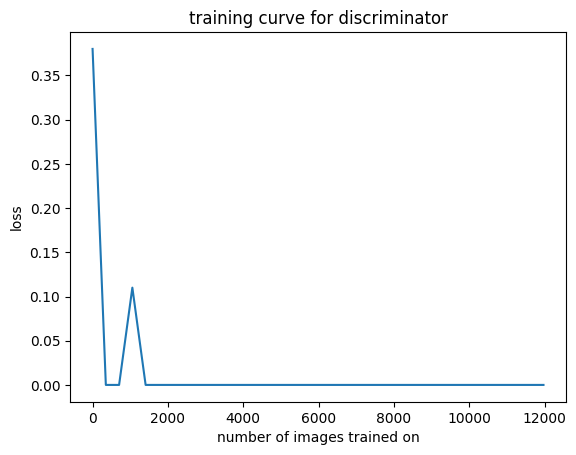

In [13]:
lr = 0.0001               # The size of the step taken when doing gradient descent
batch_size = 32        # The number of images being trained on at once
update_interval = 11   # The number of batches trained on before recording loss
n_epochs = 5            # The number of times we train through the entire dataset
noise_samples = 256    # The size of the noise input to the Generator

loss_function = nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
G_model = Generator(noise_samples, (3,512,512)).to(device)
D_model = Discriminator((3,512,512)).to(device)
G_optimizer = torch.optim.Adam(G_model.parameters(), lr=lr*2)     # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima
D_optimizer = torch.optim.Adam(D_model.parameters(), lr=lr)       # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima

train_dataset = dataset

models, losses = training(G_model, D_model, loss_function, G_optimizer, D_optimizer, train_dataset, n_epochs, update_interval, noise_samples)

G_model, D_model = models
g_losses, d_losses = losses

plt.plot(np.arange(len(g_losses)) * batch_size * update_interval, g_losses)
plt.title("training curve for generator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

plt.plot(np.arange(len(d_losses)) * batch_size * update_interval, d_losses)
plt.title("training curve for discriminator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [15]:
# Assuming you have a function plot_image to display images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device if it's not already
D_model.to(device)
G_model.to(device)

# Make sure the example image 'ex_image' is on the correct device
ex_image = ex_image.to(device).float()  # Convert to float and move to GPU
trained_output = D_model(ex_image)

# Assuming plot_image handles tensors on CPU
plot_image(ex_image.cpu().detach())  # Move tensor back to CPU for plotting
print("Output of the discriminator given this input:", trained_output[0].detach().cpu().numpy()[0])
plt.show()

# Generate noise and process it through the generator
noise = (torch.rand(1, noise_samples, device=device) - 0.5) / 0.5  # Create noise directly on the GPU
trained_gen = G_model(noise)

# Assuming plot_image handles tensors on CPU
plot_image(trained_gen.detach().cpu())  # Move tensor back to CPU for plotting

# Pass the generated image through the discriminator
trained_output = D_model(trained_gen.float())  # Ensure the generated image is float

print("Output of the discriminator given this generated input:", trained_output[0].detach().cpu().numpy()[0])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x262144 and 4194304x128)

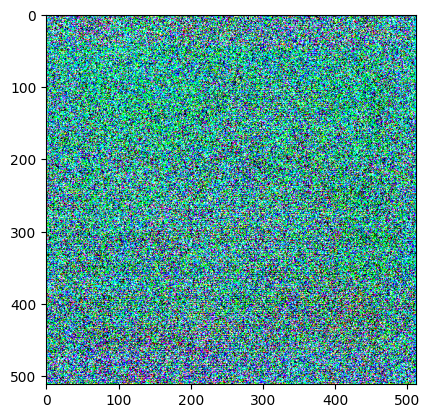

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure that G_model is on the correct device
G_model = G_model.to(device)

# Generate noise on the same device as G_model
noise = (torch.rand(1, 256, device=device) - 0.5) / 0.5

# Pass noise through the generator and then move the result to CPU for plotting
trained_output = G_model(noise).cpu()

# Call plot_image with the detached tensor
plot_image(trained_output.detach())

In [ ]:
import itertools

# Define hyperparameters options
lr_options = [2e-4, 1e-4, 3e-4, 9e-3, 5e-4]
batch_size_options = [16, 32, 64, 128]
noise_size_options = [256, 512, 1024, 2048]
update_interval_options = [10, 9, 11]
n_epochs_options = [5]

# Generate all combinations of hyperparameters
all_combinations = list(itertools.product(lr_options, batch_size_options, noise_size_options, update_interval_options, n_epochs_options))

# Keep track of the best hyperparameters and their performance
best_loss = float('inf')
best_hyperparams = {}

for combination in all_combinations:
    # Unpack the hyperparameters
    lr, batch_size, noise_size, update_interval, n_epochs = combination
    
    # Assuming the CelebA image shape
    image_shape = (3, 109, 89)
    
    # Create your model, optimizer, dataloader, etc. using these hyperparameters
    generator = Generator(noise_size, image_shape).to(device)
    discriminator = Discriminator(image_shape).to(device)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    # Assume dataloader is defined elsewhere with the given batch_size
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Assume the existence of a function `training` that trains your model and returns the final loss
    _, losses = training(generator, discriminator, nn.BCELoss(), g_optimizer, d_optimizer, dataset, n_epochs, update_interval, noise_size)
    
    # Compute the average loss
    g_losses, d_losses = losses
    avg_loss = (sum(g_losses) / len(g_losses)) + (sum(d_losses) / len(d_losses))
    avg_loss /= 2  # Because we added two losses, we take their average
    
    # Compare the final loss with the best one seen so far
    print(f"Average Loss for combination {combination}: {avg_loss}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_hyperparams = {
            'lr': lr,
            'batch_size': batch_size,
            'noise_size': noise_size,
            'update_interval': update_interval,
            'n_epochs': n_epochs
        }

# Output the best hyperparameters and their performance
print(f"Best Loss: {best_loss}")
print(f"Best Hyperparameters: {best_hyperparams}")
